# SSD300 Inference Tutorial

This is a brief tutorial that shows how to use a trained SSD300 for inference on the Pascal VOC datasets. If you'd like more detailed explanations, please refer to [`ssd300_training.ipynb`](https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd300_training.ipynb)

In [1]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt

from keras_ssd300 import ssd_300
from keras_ssd_loss import SSDLoss
from keras_layer_AnchorBoxes import AnchorBoxes
from keras_layer_L2Normalization import L2Normalization
from ssd_box_encode_decode_utils import decode_y, decode_y2
from ssd_batch_generator import BatchGenerator

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set the image size.
img_height = 400
img_width = 600

## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [3]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, 3),
                n_classes=20,
                l2_regularization=0.0005,
                scales=[0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05], # The scales for MS COCO are [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
                aspect_ratios_per_layer=[[1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                                         [1.0, 2.0, 0.5],
                                         [1.0, 2.0, 0.5]],
                two_boxes_for_ar1=True,
                steps=[8, 16, 32, 64, 100, 300],
                offsets=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
                limit_boxes=False,
                variances=[0.1, 0.1, 0.2, 0.2],
                coords='centroids',
                normalize_coords=True,
                subtract_mean=[123, 117, 104],
                swap_channels=True)

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.

weights_path = 'ssd300_weights_epoch-01_loss-0.0005_val_loss-0.0000.h5'

model.load_weights(weights_path, by_name=True)

# 3: Compile the model so that Keras won't complain the next time you load it.

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-04)

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


Or

### 1.2. Load a trained model

In [4]:
# # TODO: Set the path to the `.h5` file of the model to be loaded.
# model_path = 'ssd300.h5'

# # We need to create an SSDLoss object in order to pass that to the model loader.
# ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

# K.clear_session() # Clear previous models from memory.

# model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
#                                                'L2Normalization': L2Normalization,
#                                                'compute_loss': ssd_loss.compute_loss})

## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [5]:
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.
img_path = '../Dataset/Validation/cjwfrur8nktth0838womzts1t.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(img_height, img_width))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

C:\Users\y_sta\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


## 3. Make predictions and decode them

In [6]:
y_pred = model.predict(input_images)

In [7]:
y_pred_decoded = decode_y(y_pred,
                          confidence_thresh=0.04,
                          iou_threshold=0.45,
                          top_k=100,
                          input_coords='centroids',
                          normalize_coords=True,
                          img_height=img_height,
                          img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('    class    conf  xmin     ymin   xmax    ymax')
print(y_pred_decoded[0])

Predicted boxes:

    class    conf  xmin     ymin   xmax    ymax
[[  8.     0.05 157.86 167.72 186.14 224.28]
 [  8.     0.05 429.86 167.72 458.14 224.28]
 [  8.     0.05 189.86 167.72 218.14 224.28]
 [  8.     0.05 237.86 167.72 266.14 224.28]
 [  8.     0.05 221.86 167.72 250.14 224.28]
 [  8.     0.05 117.86 151.72 146.14 208.28]
 [  8.     0.05 125.86 167.72 154.14 224.28]
 [  8.     0.05 397.86 167.72 426.14 224.28]
 [  8.     0.05 445.86 167.72 474.14 224.28]
 [  8.     0.05 461.86 167.72 490.14 224.28]
 [  8.     0.05 477.86 167.72 506.14 224.28]
 [  8.     0.05 493.86 167.72 522.14 224.28]
 [  8.     0.05 509.86 167.72 538.14 224.28]
 [  8.     0.05 525.86 167.72 554.14 224.28]
 [  8.     0.05 541.86 167.72 570.14 224.28]
 [  8.     0.05 557.86 167.72 586.14 224.28]
 [  8.     0.05 573.86 167.72 602.14 224.28]
 [  8.     0.05   5.86 175.72  34.14 232.28]
 [  8.     0.05  21.86 175.72  50.14 232.28]
 [  8.     0.05  37.86 175.72  66.14 232.28]
 [  8.     0.05  53.86 175.72  82.

## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

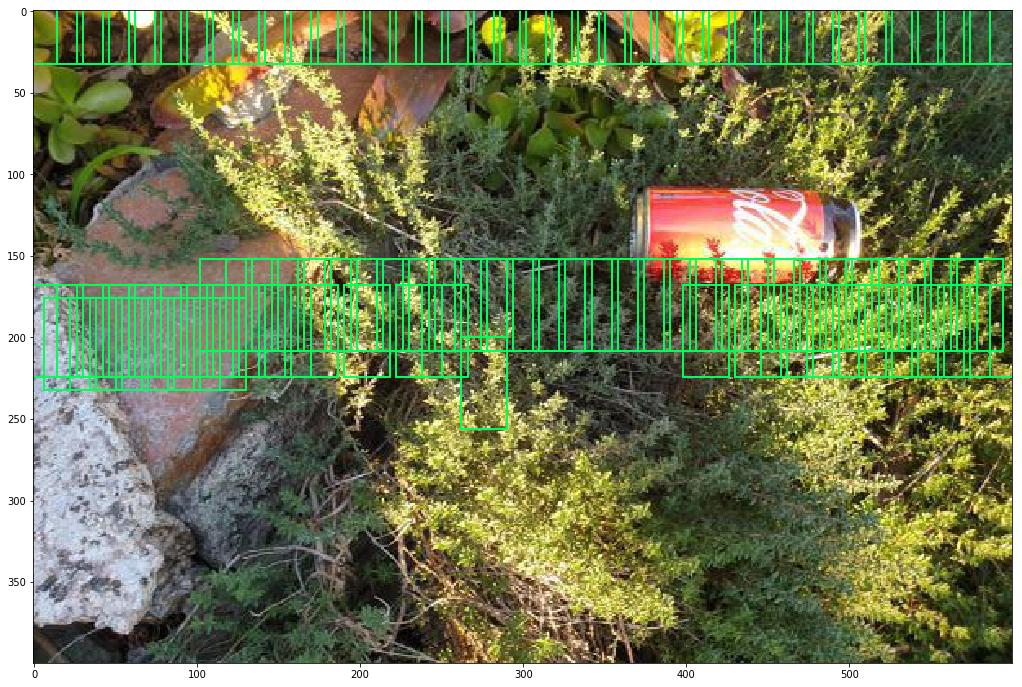

In [8]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
classes = ['Plastic Bottle']

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_decoded[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[-4] * orig_images[0].shape[1] / img_width
    ymin = box[-3] * orig_images[0].shape[0] / img_height
    xmax = box[-2] * orig_images[0].shape[1] / img_width
    ymax = box[-1] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
#     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
#     current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

## 5. Make predictions on Pascal VOC 2007 Test

Let's use the batch generator to make predictions on the Pascal VOC 2007 test dataset and visualize the predicted boxes alongside the ground truth boxes for comparison.

In [9]:
# # Create a `BatchGenerator` instance and parse the Pascal VOC labels.

# dataset = BatchGenerator(box_output_format=['class_id', 'xmin', 'ymin', 'xmax', 'ymax'])

# # TODO: Set the paths to the datasets here.

# VOC_2007_test_images_dir         = '../../datasets/VOCdevkit/VOC2007_Test/JPEGImages/'
# VOC_2007_test_annotations_dir    = '../../datasets/VOCdevkit/VOC2007_Test/Annotations/'
# VOC_2007_test_image_set_filename = '../../datasets/VOCdevkit/VOC2007_Test/ImageSets/Main/test.txt'

# # The XML parser needs to now what object class names to look for and in which order to map them to integers.
# classes = ['background',
#            'aeroplane', 'bicycle', 'bird', 'boat',
#            'bottle', 'bus', 'car', 'cat',
#            'chair', 'cow', 'diningtable', 'dog',
#            'horse', 'motorbike', 'person', 'pottedplant',
#            'sheep', 'sofa', 'train', 'tvmonitor']

# dataset.parse_xml(images_dirs=[VOC_2007_test_images_dir],
#                   image_set_filenames=[VOC_2007_test_image_set_filename],
#                   annotations_dirs=[VOC_2007_test_annotations_dir],
#                   classes=classes,
#                   include_classes='all',
#                   exclude_truncated=False,
#                   exclude_difficult=True,
#                   ret=False)

# generator = dataset.generate(batch_size=1,
#                              shuffle=True,
#                              train=False,
#                              returns={'processed_images',
#                                       'filenames',
#                                       'inverse_transform',
#                                       'original_images',
#                                       'original_labels'},
#                              max_crop_and_resize=False,
#                              random_pad_and_resize=False,
#                              resize=(img_height,img_width))

In [10]:
# # Generate a batch and make predictions.

# batch_X, batch_filenames, batch_inverse_coord_transform, batch_original_images, batch_original_labels = next(generator)

# i = 0 # Which batch item to look at

# print("Image:", batch_filenames[i])
# print()
# print("Ground truth boxes:\n")
# print(np.array(batch_original_labels[i]))

In [11]:
# # Predict.

# y_pred = model.predict(batch_X)

In [12]:
# # Decode the predictions.

# y_pred_decoded = decode_y(y_pred,
#                           confidence_thresh=0.5,
#                           iou_threshold=0.45,
#                           top_k=200,
#                           input_coords='centroids',
#                           normalize_coords=True,
#                           img_height=img_height,
#                           img_width=img_width)

# np.set_printoptions(precision=2, suppress=True, linewidth=90)
# print("Predicted boxes:\n")
# print('    class    conf  xmin    ymin    xmax    ymax')
# print(y_pred_decoded[i])

In [13]:
# # Display the image and draw the predicted boxes onto it.

# # Set the colors for the bounding boxes
# colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

# plt.figure(figsize=(20,12))
# plt.imshow(batch_original_images[i])

# current_axis = plt.gca()

# for box in batch_original_labels[i]:
#     xmin = box[1]
#     ymin = box[2]
#     xmax = box[3]
#     ymax = box[4]
#     label = '{}'.format(classes[int(box[0])])
#     current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
#     current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

# for k, box in enumerate(y_pred_decoded[i]):
#     # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
#     xmin = (box[-4] * batch_inverse_coord_transform[i,0,1]) + batch_inverse_coord_transform[i,0,0]
#     ymin = (box[-3] * batch_inverse_coord_transform[i,1,1]) + batch_inverse_coord_transform[i,1,0]
#     xmax = (box[-2] * batch_inverse_coord_transform[i,2,1]) + batch_inverse_coord_transform[i,2,0]
#     ymax = (box[-1] * batch_inverse_coord_transform[i,3,1]) + batch_inverse_coord_transform[i,3,0]
#     color = colors[int(box[0])]
#     label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
#     current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
#     current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

As you can see above, sometimes the model performs quite plausible failures. I would argue that the potted plant is actually much more a part of this image than the chair.